# DirectView as multiplexer

In [1]:
import os,sys,time
import numpy as np

from IPython.core.display import display
from IPython import parallel
rc = parallel.Client()

The DirectView can be readily understood as an Engine Multiplexer -
it does the same thing on all of its engines.

The only difference between running code on a single remote engine
and running code in parallel is how many engines the DirectView is
instructed to use.

You can create DirectViews by index-access to the Client.  This creates
a DirectView using the engines after passing the same index (or slice)
to the `ids` list.

In [2]:
e0 = rc[0]
engines = rc[:]
even = rc[::2]
odd = rc[1::2]

# this is the one we are going to use:
dview = engines
dview.block = True

Now, the only difference from single-engine remote execution is that the code we run happens on all of the engines of a given view:

In [3]:
for view in (e0, engines, even, odd):
    print(view, view.apply_sync(os.getpid))

<DirectView 0> 8191
<DirectView [0, 1, 2, 3]> [8191, 8196, 8197, 8198]
<DirectView [0, 2]> [8191, 8197]
<DirectView [1, 3]> [8196, 8198]


The results of multiplexed execution is always a list of the length of the number of engines.

In [4]:
engines['a'] = 5
engines['a']

[5, 5, 5, 5]

# Scatter and Gather

Lots of parallel computations involve partitioning data onto processes.  
DirectViews have `scatter()` and `gather()` methods, to help with this.
Pass any container or numpy array, and IPython will partition the object onto the engines wih `scatter`,
or reconstruct the full object in the Client with `gather()`.

In [5]:
dview.scatter('a', list(range(16)))
dview['a']

[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]]

In [6]:
dview.gather('a')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [7]:
dview.execute("asum = sum(a)")
dview.gather('asum')

[6, 22, 38, 54]

We can pass a 'flatten' keyword,
to instruct engines that will only get one item of the list to
get the actual item, rather than a one-element sublist:

In [8]:
dview.scatter('id', rc.ids)
dview['id']

[[0], [1], [2], [3]]

In [9]:
dview.scatter('id', rc.ids, flatten=True)
dview['id']

[0, 1, 2, 3]

Scatter and gather also work with numpy arrays

In [10]:
A = np.random.randint(1,10,(16,4))
B = np.random.randint(1,10,(4,16))
display(A)
display(B)

array([[2, 5, 3, 4],
       [5, 2, 7, 9],
       [5, 2, 1, 7],
       [1, 7, 2, 9],
       [9, 8, 9, 7],
       [2, 4, 4, 2],
       [6, 3, 4, 3],
       [7, 6, 1, 4],
       [6, 3, 1, 1],
       [7, 9, 7, 9],
       [1, 2, 9, 7],
       [9, 9, 1, 9],
       [9, 4, 2, 7],
       [3, 1, 3, 2],
       [8, 4, 4, 4],
       [2, 5, 3, 1]])

array([[8, 5, 1, 9, 5, 6, 5, 7, 6, 8, 2, 1, 3, 6, 2, 9],
       [9, 5, 4, 2, 5, 5, 2, 1, 8, 7, 6, 1, 9, 8, 8, 3],
       [6, 6, 9, 9, 2, 9, 3, 4, 5, 6, 7, 3, 5, 8, 8, 9],
       [6, 1, 9, 3, 2, 4, 1, 2, 6, 3, 1, 4, 1, 9, 4, 3]])

In [11]:
dview.scatter('A', A)
dview.scatter('B', B)
display(e0['A'])
display(e0['B'])

array([[2, 5, 3, 4],
       [5, 2, 7, 9],
       [5, 2, 1, 7],
       [1, 7, 2, 9]])

array([[8, 5, 1, 9, 5, 6, 5, 7, 6, 8, 2, 1, 3, 6, 2, 9]])

## Excercise: Parallel Matrix Multiply

Can you compute the Matrix product `C=A.dot(B)` in parallel? (not looking for brilliant, just correct).


In [12]:
%run ../hints
mmhint()

In [14]:
%load ../soln/matmul.py

Let's run this, and validate the result against a local computation.

In [15]:
C_ref = A.dot(B)
C1 = pdot(dview, A, B)
# validation:
(C1==C_ref).all()

True

# Map

DirectViews have a map method, which behaves just like the builtin map,
but computed in parallel.

In [17]:
dview.block = True

serial_result   =  list(map(lambda x:x**10, range(32)))
parallel_result = dview.map(lambda x:x**10, range(32))

serial_result == parallel_result

True

`DirectView.map` partitions the sequences onto each engine,
and then calls `map` remotely.  The result is always a single
IPython task per engine.

In [18]:
amr = dview.map_async(lambda x:x**10, range(32))
amr.msg_ids

['7e1efd28-1183-40aa-b00b-e628d373bcbb',
 'a9081bb8-9323-42da-bac4-b7423b14dced',
 'd94f23d9-a35e-47b2-b17b-05d67afd52f8',
 '1ab03e16-30c0-4272-a5a0-e62ce198ee3c']

In [19]:
amr = dview.map_async(lambda x:x**10, range(3200))
amr.msg_ids

['5684a5a3-2a68-4175-a4f8-7047eb25189d',
 '95cc9924-0fd9-475b-932f-06fe71b7761a',
 '9fed408b-13cc-489a-aa26-42bc00b2498d',
 '837aafca-83a7-4a34-a31a-f1be44859a53']

### The motivating example

In [20]:
from IPython.display import display, Image
%run ../images_common

enabling inline matplotlib


In [21]:
pictures = get_pictures(os.path.join('..', 'images', 'castle'))

In [22]:
%px cd {os.getcwd()}

[stdout:0] /Users/minrk/dev/jpy/ngcm-tutorial/Day-3/tutorial
[stdout:1] /Users/minrk/dev/jpy/ngcm-tutorial/Day-3/tutorial
[stdout:2] /Users/minrk/dev/jpy/ngcm-tutorial/Day-3/tutorial
[stdout:3] /Users/minrk/dev/jpy/ngcm-tutorial/Day-3/tutorial


In [23]:
%%px
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import measure

[stdout:0] enabling inline matplotlib
[stdout:1] enabling inline matplotlib
[stdout:2] enabling inline matplotlib
[stdout:3] enabling inline matplotlib


In [24]:
engines.push(dict(
    plot_contours=plot_contours,
    find_contours=find_contours,
))

[None, None, None, None]

   1/1 tasks finished after    3 s
done


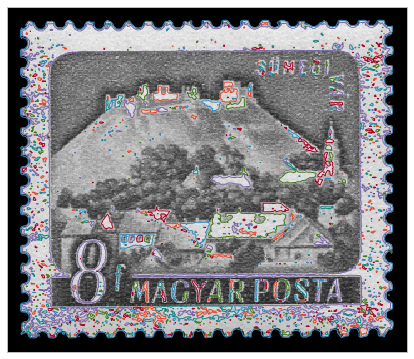

In [26]:
ar = e0.apply_async(get_contours_image, pictures[0])
ar.wait_interactive()
Image(data=ar.get())

   4/4 tasks finished after    7 s
done


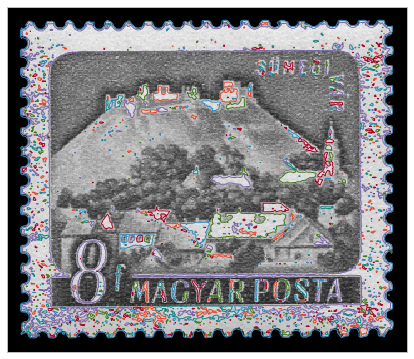

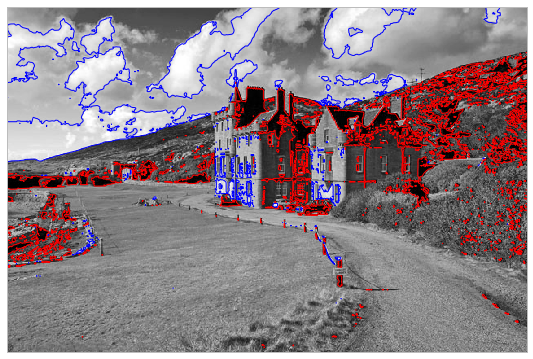

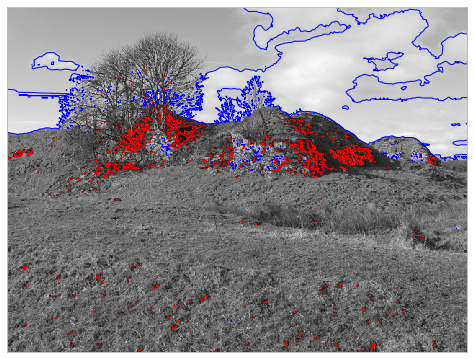

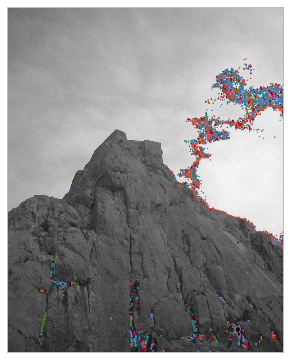

In [27]:
amr = engines.map_async(get_contours_image, pictures[:len(engines)])
amr.wait_interactive()
for pngdata in amr:
    display(Image(data=pngdata))

## Exercises and Examples

- [Remote Iteration](../exercises/Remote%20Iteration.ipynb)
- [Monte Carlo π](../exercises/Monte%20Carlo%20π.ipynb)

# Moving on

IPython.parallel can also be used for [load-balanced execution](Load-Balancing.ipynb),
when you just want code to run, but don't care where.